In [1]:

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import IPython
import os
import math

import torch

In [2]:
os.chdir('C:/Users/trist/Downloads/jets/jets')

train = 200000
test = 20000
val = 20000

files = train+test+val
count = 0

num_constituents = 100
num_features = 4
num_classes = 5

input_feature_values = np.zeros((files,num_features,num_constituents)) #Form (N,C,P) 
targets = np.zeros((files,num_classes))
for file in tqdm.tqdm(os.listdir()):
    if files <= count:
        break
    with np.load(file) as data:

        input_val = data['x'][:,1:] #Info on eta, phi, energy, R
        input_val[:,2] = 2*np.maximum(np.log(input_val[:,2])+13,0*input_val[:,2])/13 #Scales data to around 0-2

        if len(input_val) > num_constituents:
            input_val = input_val[:num_constituents]
        else:
            input_val = np.pad(input_val, ((0,num_constituents-len(input_val)),(0,0)), 'constant') #Zero padding to make contiguous

        input_feature_values[count] = input_val.T #Transpose so of form (N,C,P)       
        targets[count] = np.reshape(data['y'],(1,5))
        count += 1

 24%|█████████████████▋                                                       | 240000/987684 [04:50<15:04, 826.77it/s]


In [3]:

print(targets[0])

print(input_feature_values[0])

print(input_feature_values[0].shape)

[1. 0. 0. 0. 0.]
[[-0.00000000e+00 -1.07198460e-02 -2.81282309e-02 -5.46307769e-03
   1.69488508e-03 -2.47465335e-02 -2.90216580e-02  1.78072578e-03
  -2.25291047e-02 -5.20522334e-03 -2.86652241e-02 -4.26899269e-03
  -7.69114867e-03 -1.34355836e-02 -3.43648046e-02 -1.42659480e-02
  -1.58805661e-02 -2.82836761e-02 -3.30038406e-02 -3.77037115e-02
   7.94646703e-03  8.59526731e-03  1.47442827e-02  4.80596907e-03
  -2.61173621e-02  3.25068226e-03 -2.07644259e-03 -4.32132371e-02
  -2.67829280e-02 -2.92214192e-02 -3.41079682e-02 -1.45875914e-02
  -6.88248221e-03  4.90555279e-02  2.82599939e-14 -9.23825987e-03
  -1.92290656e-02  1.02186883e-02  1.86074898e-02 -2.78790109e-03
  -1.23392995e-02 -6.32671639e-02 -1.27385825e-01 -4.45788503e-02
  -1.86683368e-02  2.33146176e-02  6.82846382e-02 -1.41734176e-03
  -2.87821386e-02 -1.08740047e-01 -7.83728212e-02 -3.59309539e-02
   5.39334975e-02  1.72874629e-01 -7.05009550e-02 -5.31759523e-02
  -3.04253399e-02  3.55592251e-01 -3.10482651e-01 -2.533223

In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, YUUKI, target):
        self.inputs = YUUKI
        self.target = target
    def __len__(self):
            return len(self.target)
    def __getitem__(self, idx):
            inputs = self.inputs[idx]
            target = self.target[idx]
            sample = {"input": inputs, "target": target}
            return sample
        
train_Dataset = CustomDataset(input_feature_values[:train], targets[:train])
print(targets[train:train+test].shape)
test_Dataset = CustomDataset(input_feature_values[train:train+test], targets[train:train+test])
val_Dataset = CustomDataset(input_feature_values[-val:], targets[-val:])

(20000, 5)


In [5]:
#Taken from https://github.com/jet-universe/particle_transformer/blob/main/networks/example_PFN.py

import torch.nn as nn

class ParticleFlowNetwork(nn.Module):
    r"""Parameters
    ----------
    input_dims : int
        Input feature dimensions.
    num_classes : int
        Number of output classes.
    layer_params : list
        List of the feature size for each layer.
    """

    def __init__(self, input_dims, num_classes,
                 Phi_sizes=(100, 100, 128),
                 F_sizes=(100, 100, 100),
                 use_bn=True,
                 for_inference=False,
                 **kwargs):

        super(ParticleFlowNetwork, self).__init__(**kwargs)
        # input bn
        self.input_bn = nn.BatchNorm1d(input_dims) if use_bn else nn.Identity()
        # per-particle functions
        phi_layers = []
        for i in range(len(Phi_sizes)):
            phi_layers.append(nn.Sequential(
                nn.Conv1d(input_dims if i == 0 else Phi_sizes[i - 1], Phi_sizes[i], kernel_size=1),
                nn.BatchNorm1d(Phi_sizes[i]) if use_bn else nn.Identity(),
                nn.ReLU())
            )
        self.phi = nn.Sequential(*phi_layers)
        
        # global functions
        f_layers = []
        for i in range(len(F_sizes)):
            f_layers.append(nn.Sequential(
                nn.Linear(Phi_sizes[-1] if i == 0 else F_sizes[i - 1], F_sizes[i]),
                nn.ReLU())
            )
        f_layers.append(nn.Linear(F_sizes[-1], num_classes))
        if for_inference:
            f_layers.append(nn.Softmax(dim=1))
        self.fc = nn.Sequential(*f_layers)

    def forward(self, features, mask):
        # x: the feature vector initally read from the data structure, in dimension (N, C, P)
        x = self.input_bn(features)
        x = self.phi(x)
        if mask is not None:
            x = x * mask.bool().float()
        x = x.sum(-1)
        return self.fc(x)

In [19]:
learning_rate = 1e-3
epochs = 30
batch_size = 32

model = ParticleFlowNetwork(4,5,Phi_sizes=(256, 192, 128), F_sizes=(100, 100, 100),use_bn=True)
model.cuda()

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
train_DataLoader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_DataLoader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=True)
val_DataLoader = DataLoader(val_Dataset, batch_size=batch_size, shuffle=True)

In [21]:
train_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []

data = next(iter(train_DataLoader))
print(data['input'].shape,data['target'].shape)
print(type(data['input'][1,1,1]),data['target'].shape)


torch.Size([32, 4, 100]) torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 5])


In [22]:

for epoch in tqdm.trange(epochs):
    if epoch % 10 == 0: #Every 10 epochs, reduce LR by 3
        for g in optimizer.param_groups:
            g['lr'] = g['lr'] / 3 
                
    train_correct = 0
    for data in train_DataLoader:
        optimizer.zero_grad()

        input_batch = data["input"].float().cuda()
        output_targets = data["target"].float().cuda()

        train_batch_outputs = model(input_batch, None)

        loss = loss_func(train_batch_outputs, output_targets)

        correct = (torch.argmax(train_batch_outputs, dim=1) == 
                       torch.argmax(output_targets,dim=1)).type(torch.FloatTensor)
            
        train_loss_list.append(loss.item())
        
        train_correct += int(correct.sum())
            
        loss.backward()

        optimizer.step()
        
    train_accuracy_list.append(train_correct/train)

    with torch.no_grad():
        val_correct = 0
        for data in val_DataLoader:
            input_batch = data["input"].float().cuda()
            output_targets = data["target"].float().cuda()
            
            out = model(input_batch,None)
            loss = loss_func(out, output_targets)
            correct = (torch.argmax(out, dim=1) == 
                       torch.argmax(output_targets, dim=1)).type(torch.FloatTensor)
            val_correct += int(correct.sum())
        validation_accuracy_list.append(val_correct/val)
    print("Epoch "+str(epoch+1) + ": " + str(validation_accuracy_list[-1]))

  3%|██▊                                                                                | 1/30 [00:47<23:09, 47.92s/it]

Epoch 0: 0.71125


  7%|█████▌                                                                             | 2/30 [01:33<21:36, 46.32s/it]

Epoch 1: 0.712


 10%|████████▎                                                                          | 3/30 [02:19<20:57, 46.56s/it]

Epoch 2: 0.6923


 13%|███████████                                                                        | 4/30 [03:06<20:05, 46.36s/it]

Epoch 3: 0.7273


 17%|█████████████▊                                                                     | 5/30 [03:52<19:21, 46.47s/it]

Epoch 4: 0.73915


 20%|████████████████▌                                                                  | 6/30 [04:40<18:42, 46.77s/it]

Epoch 5: 0.7436


 23%|███████████████████▎                                                               | 7/30 [05:26<17:56, 46.80s/it]

Epoch 6: 0.7452


 27%|██████████████████████▏                                                            | 8/30 [06:13<17:05, 46.59s/it]

Epoch 7: 0.7438


 30%|████████████████████████▉                                                          | 9/30 [07:00<16:23, 46.81s/it]

Epoch 8: 0.7515


 33%|███████████████████████████▎                                                      | 10/30 [07:49<15:49, 47.46s/it]

Epoch 9: 0.75435


 37%|██████████████████████████████                                                    | 11/30 [08:39<15:20, 48.44s/it]

Epoch 10: 0.75675


 40%|████████████████████████████████▊                                                 | 12/30 [09:26<14:23, 47.95s/it]

Epoch 11: 0.76275


 43%|███████████████████████████████████▌                                              | 13/30 [10:12<13:22, 47.21s/it]

Epoch 12: 0.758


 47%|██████████████████████████████████████▎                                           | 14/30 [10:57<12:25, 46.57s/it]

Epoch 13: 0.76095


 50%|█████████████████████████████████████████                                         | 15/30 [11:42<11:33, 46.20s/it]

Epoch 14: 0.76085


 53%|███████████████████████████████████████████▋                                      | 16/30 [12:27<10:41, 45.85s/it]

Epoch 15: 0.7551


 57%|██████████████████████████████████████████████▍                                   | 17/30 [13:12<09:52, 45.56s/it]

Epoch 16: 0.7645


 60%|█████████████████████████████████████████████████▏                                | 18/30 [14:00<09:13, 46.14s/it]

Epoch 17: 0.75905


 63%|███████████████████████████████████████████████████▉                              | 19/30 [14:49<08:39, 47.25s/it]

Epoch 18: 0.76005


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [15:36<07:49, 46.97s/it]

Epoch 19: 0.7611


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [16:21<06:58, 46.53s/it]

Epoch 20: 0.76215


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [17:06<06:08, 46.07s/it]

Epoch 21: 0.7655


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [17:51<05:20, 45.76s/it]

Epoch 22: 0.7677


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [18:36<04:33, 45.54s/it]

Epoch 23: 0.76755


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [19:22<03:47, 45.53s/it]

Epoch 24: 0.76635


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [20:08<03:03, 45.80s/it]

Epoch 25: 0.76845


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [20:53<02:16, 45.60s/it]

Epoch 26: 0.76715


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [21:38<01:30, 45.43s/it]

Epoch 27: 0.7688


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [22:23<00:45, 45.32s/it]

Epoch 28: 0.76805


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [23:09<00:00, 46.32s/it]

Epoch 29: 0.76885


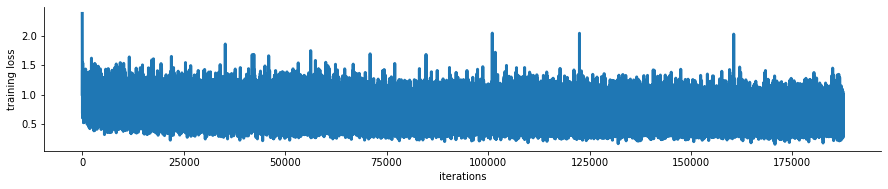

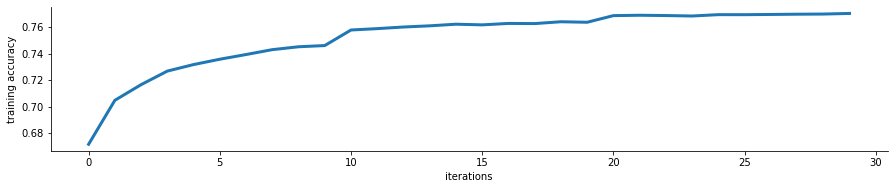

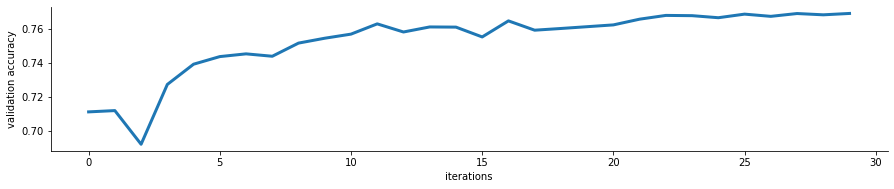

In [25]:
plt.figure(figsize = (15, 9))
plt.subplot(3, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.figure(figsize = (15, 9))
plt.subplot(3, 1, 1)
plt.plot(train_accuracy_list, linewidth = 3)
plt.ylabel("training accuracy")
plt.xlabel("iterations")
sns.despine()

plt.figure(figsize = (15, 9))
plt.subplot(3, 1, 1)
plt.plot(validation_accuracy_list, linewidth = 3)
plt.ylabel("validation accuracy")
plt.xlabel("iterations")
sns.despine()

In [26]:
print(validation_accuracy_list)

[0.71125, 0.712, 0.6923, 0.7273, 0.73915, 0.7436, 0.7452, 0.7438, 0.7515, 0.75435, 0.75675, 0.76275, 0.758, 0.76095, 0.76085, 0.7551, 0.7645, 0.75905, 0.76005, 0.7611, 0.76215, 0.7655, 0.7677, 0.76755, 0.76635, 0.76845, 0.76715, 0.7688, 0.76805, 0.76885]
